## Import Libraries

In [173]:
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PyLTSpice import RawRead
from scipy.interpolate import PchipInterpolator
from sklearn.model_selection import train_test_split

## Read LTSpice .raw Files

In [238]:
spice_raw_path = './ltspice/two_port_training_circuit/two_port_training_circuit.raw'
spice_raw = RawRead(spice_raw_path)
print(spice_raw.get_trace_names())

time_raw = spice_raw.get_axis()
time_duration = time_raw[-1]
print(f'Time duration: {time_duration}')

v1_raw = spice_raw.get_trace('V(v1)').get_wave()
v2_raw = spice_raw.get_trace('V(v2)').get_wave()
va_raw = spice_raw.get_trace('V(va)').get_wave()
v2a_raw = v2_raw - va_raw
vb_raw = spice_raw.get_trace('V(vb)').get_wave()
vc_raw = spice_raw.get_trace('V(vc)').get_wave()

['time', 'V(vc)', 'V(vb)', 'V(va)', 'V(v1)', 'V(v2)', 'Ic(Q1)', 'Ib(Q1)', 'Ie(Q1)', 'I(R1)', 'I(R2)', 'I(R3)', 'I(V1)', 'I(V2)']
Time duration: 2.0


## Resampled LTSpice Data

In [239]:
fs_target = 192e3
ts_target = 1.0 / fs_target
num_samples = np.floor(time_duration * fs_target).astype(int) + 1
time_resample = np.linspace(0, time_duration, num_samples)

v1 = PchipInterpolator(time_raw, v1_raw)(time_resample)
v2 = PchipInterpolator(time_raw, v2a_raw)(time_resample)
va = PchipInterpolator(time_raw, va_raw)(time_resample)
vb = PchipInterpolator(time_raw, vb_raw)(time_resample)
vc = PchipInterpolator(time_raw, vc_raw)(time_resample)

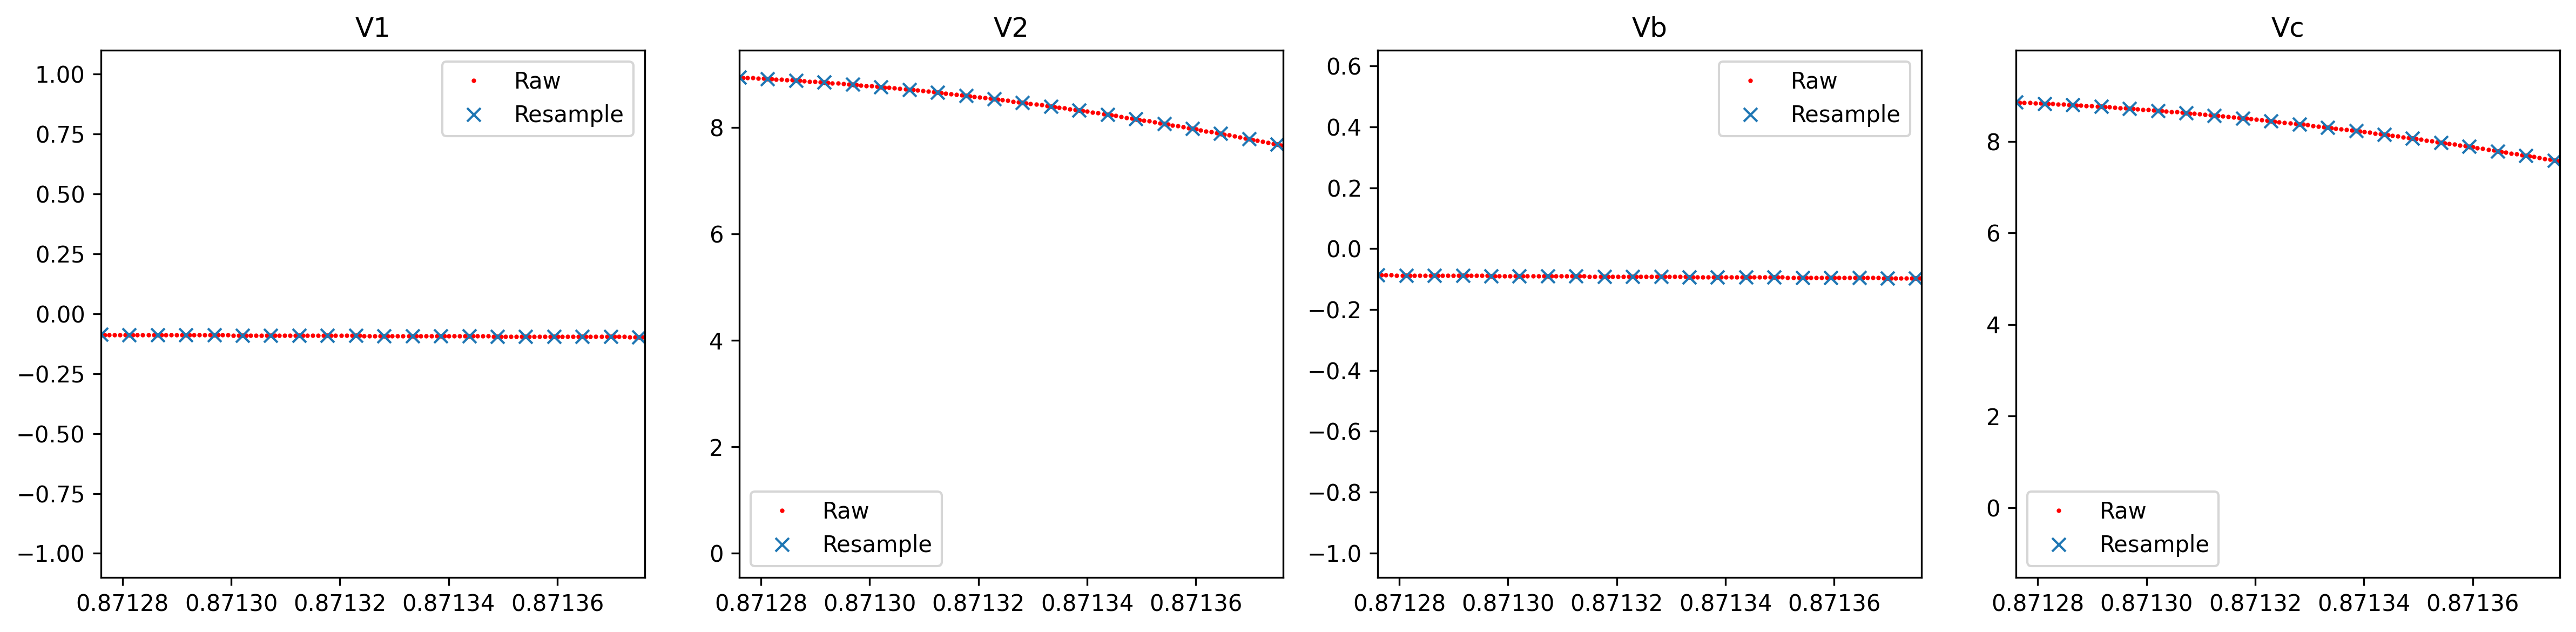

In [240]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(16, 4), dpi=300)

interval_width = 1e-4
start_x = np.random.uniform(0, time_duration - interval_width)
end_x = start_x + interval_width
xlim = (start_x, end_x)

markersize_raw = 1
markersize_resample = 6

ax1.plot(time_raw, v1_raw, 'ro', markersize=markersize_raw, label='Raw')
ax1.plot(time_resample, v1, 'x', markersize=markersize_resample, label='Resample')
ax1.set_xlim(xlim)
ax1.set_title('V1')
ax1.legend()

ax2.plot(time_raw, v2a_raw, 'ro', markersize=markersize_raw, label='Raw')
ax2.plot(time_resample, v2, 'x', markersize=markersize_resample, label='Resample')
ax2.set_xlim(xlim)
ax2.set_title('V2')
ax2.legend()

ax3.plot(time_raw, vb_raw, 'ro', markersize=markersize_raw, label='Raw')
ax3.plot(time_resample, vb, 'x', markersize=markersize_resample, label='Resample')
ax3.set_xlim(xlim)
ax3.set_title('Vb')
ax3.legend()

ax4.plot(time_raw, vc_raw, 'ro', markersize=markersize_raw, label='Raw')
ax4.plot(time_resample, vc, 'x', markersize=markersize_resample, label='Resample')
ax4.set_xlim(xlim)
ax4.set_title('Vc')
ax4.legend()

fig.tight_layout()

## Validate Resampled Data (OPTIONAL)

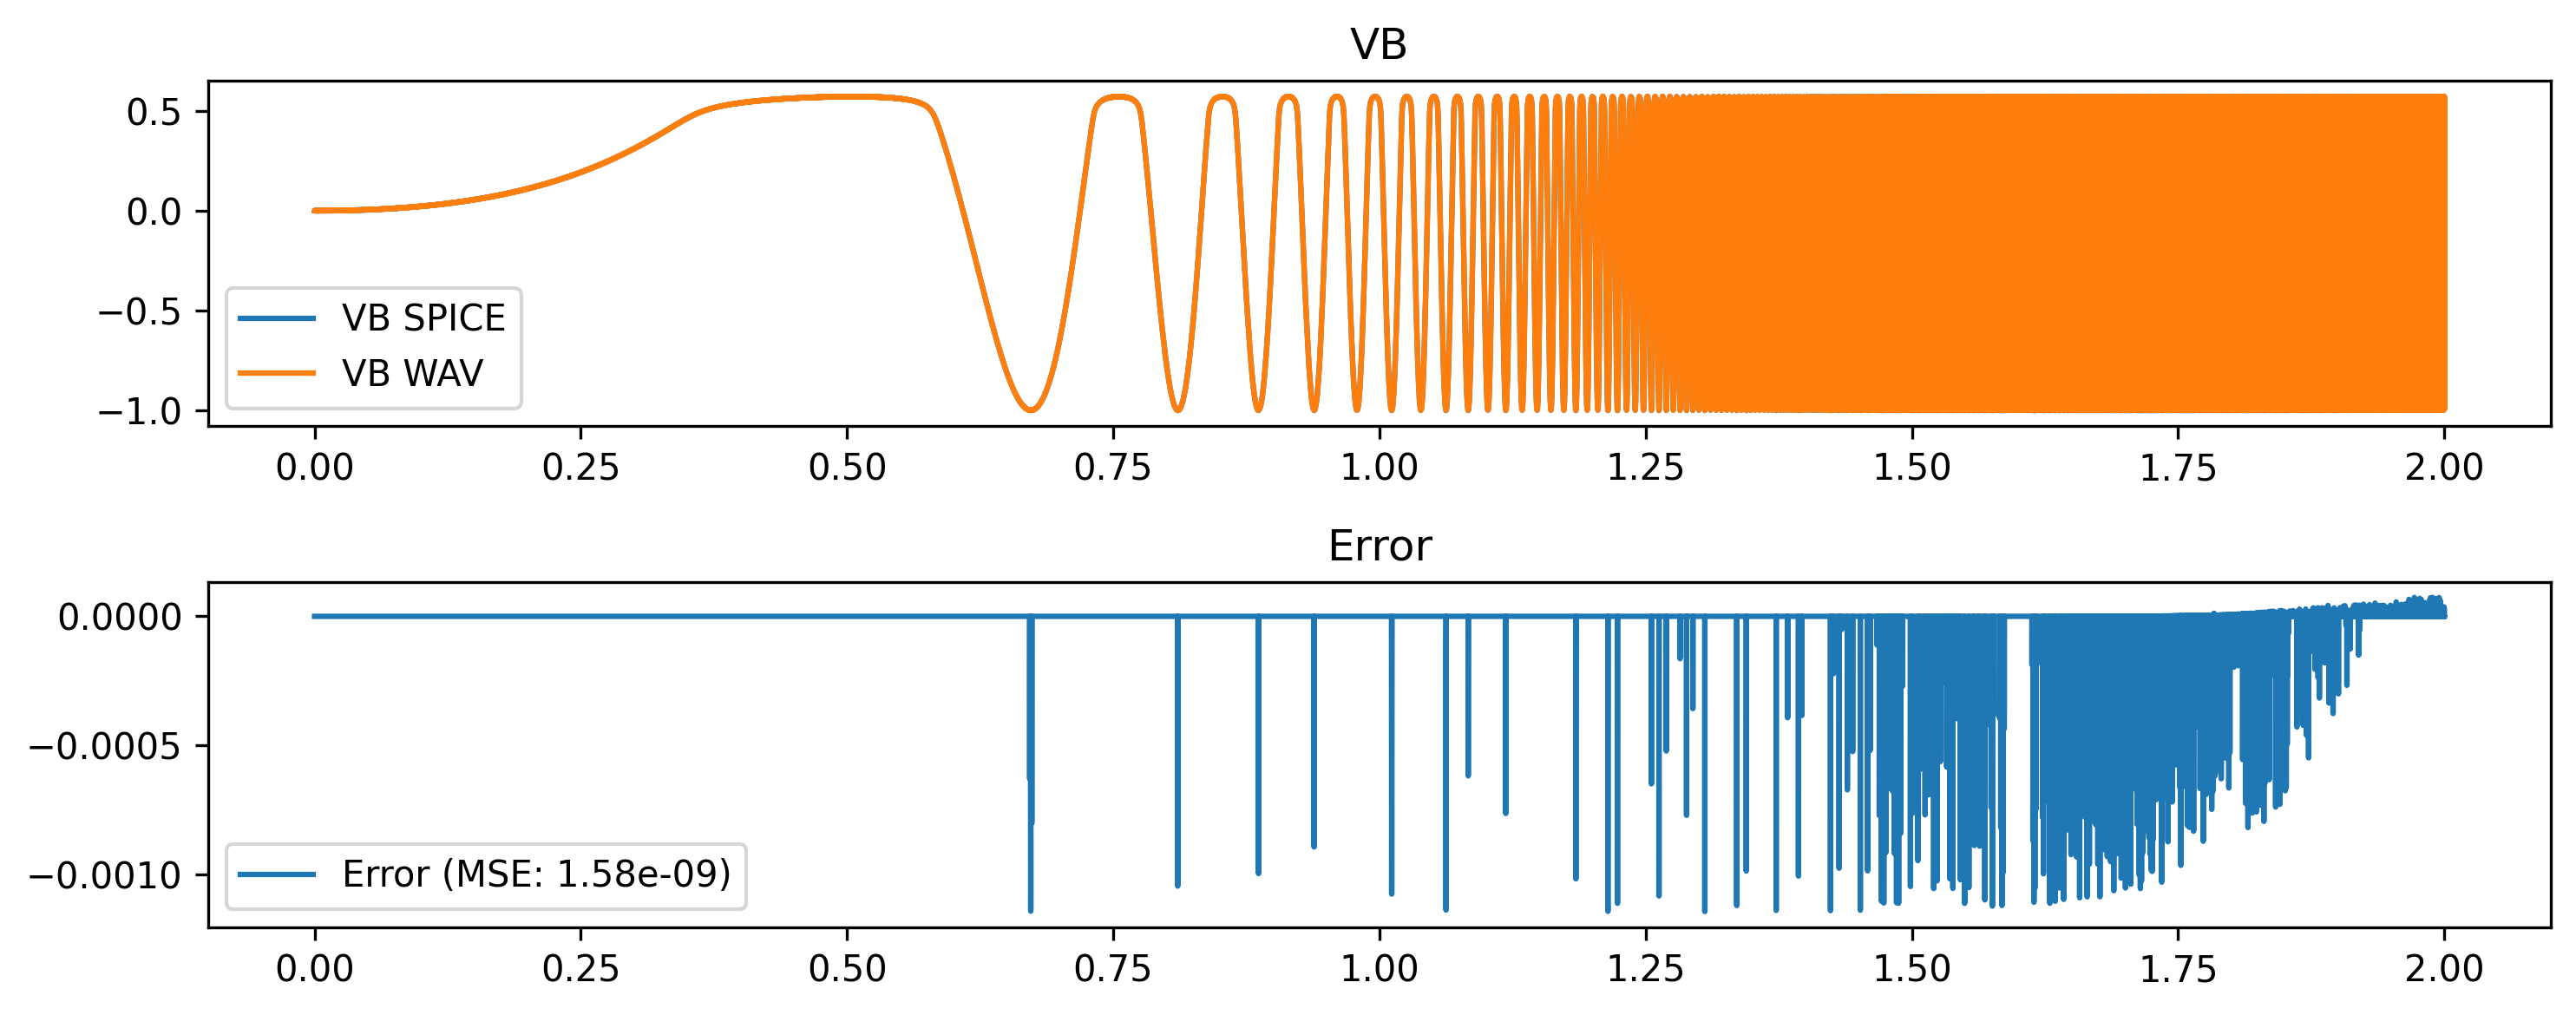

In [241]:
vb_wav, _ = librosa.load('./ltspice/two_port_training_circuit/output_vb.wav', sr=None)
error = vb - vb_wav
mse_error = np.mean(error ** 2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), dpi=300)

ax1.plot(time_resample, vb, label='VB SPICE')
ax1.plot(time_resample, vb_wav, label='VB WAV')
ax1.set_title('VB')
ax1.legend()

ax2.plot(time_resample, error, label=f'Error (MSE: {mse_error:.2e})')
ax2.set_title('Error')
ax2.legend()

fig.tight_layout()
plt.show()

## Compute Incident and Reflected Waves

In [243]:
a1 = v1
a2 = v2
b1 = 2 * vb - v1
b2 = 2 * (vc - vb) - v2

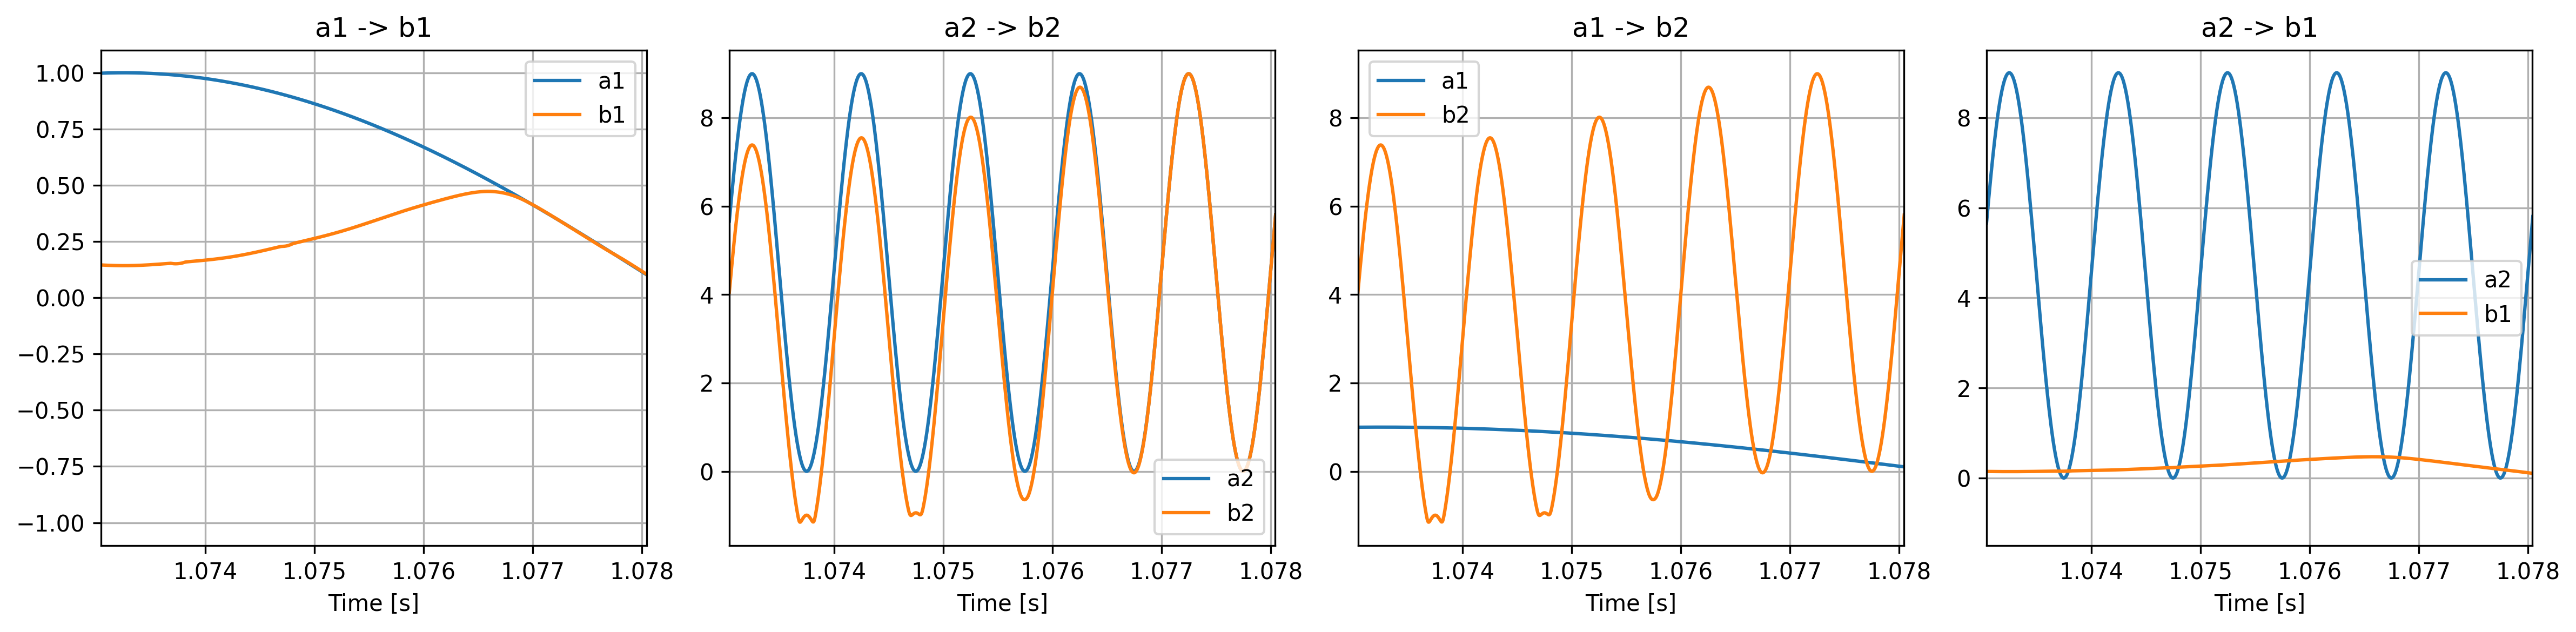

In [245]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(16, 4), dpi=300)

interval_width = 5e-3
start_x = np.random.uniform(0, time_duration - interval_width)
end_x = start_x + interval_width
xlim = (start_x, end_x)

ax1.plot(time_resample, a1, label='a1')
ax1.plot(time_resample, b1, label='b1')
ax1.set_title('a1 -> b1')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(xlim)
ax1.grid()
ax1.legend()

ax2.plot(time_resample, a2, label='a2')
ax2.plot(time_resample, b2, label='b2')
ax2.set_title('a2 -> b2')
ax2.set_xlabel('Time [s]')
ax2.set_xlim(xlim)
ax2.grid()
ax2.legend()

ax3.plot(time_resample, a1, label='a1')
ax3.plot(time_resample, b2, label='b2')
ax3.set_title('a1 -> b2')
ax3.set_xlabel('Time [s]')
ax3.set_xlim(xlim)
ax3.grid()
ax3.legend()

ax4.plot(time_resample, a2, label='a2')
ax4.plot(time_resample, b1, label='b1')
ax4.set_title('a2 -> b1')
ax4.set_xlabel('Time [s]')
ax4.set_xlim(xlim)
ax4.grid()
ax4.legend()

fig.tight_layout()

## Neural Two-Port Element

In [261]:
class TwoPort(nn.Module):
    def __init__(self):
        super(TwoPort, self).__init__()
        # self.bn0 = nn.BatchNorm1d(2)
        
        self.linear1 = nn.Linear(2, 16)
        # self.bn1 = nn.BatchNorm1d(16)
        self.elu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(16, 16)
        # self.bn2 = nn.BatchNorm1d(16)
        self.elu2 = nn.ReLU()
        
        self.linear3 = nn.Linear(16, 2)

    def forward(self, x):
        # x = self.bn0(x)

        x1 = self.linear1(x)
        # x = self.bn1(x)
        x1 = self.elu1(x1)

        x2 = self.linear2(x1) + x1
        # x = self.bn2(x)
        x2 = self.elu2(x2)

        x3 = self.linear3(x2) + x
        return x3

## Data Loader

In [247]:
a = np.stack((a1, a2), axis=1)
b = np.stack((b1, b2), axis=1)

a_train, a_valid, b_train, b_valid = train_test_split(
    a, b,
    train_size=0.8,
    shuffle=True
)

train_ds = TensorDataset(
    torch.tensor(a_train, dtype=torch.float32),
    torch.tensor(b_train, dtype=torch.float32),
)
valid_ds = TensorDataset(
    torch.tensor(a_valid, dtype=torch.float32),
    torch.tensor(b_valid, dtype=torch.float32)
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32 * 2)

In [248]:
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()

    def forward(self, y_true, y_pred):
        return torch.sum((y_true - y_pred)**2) / torch.sum(y_true**2)
    
class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()

    def forward(self, y_true, y_pred):
        numerator = torch.abs(torch.mean(y_true - y_pred))**2
        denominator = torch.mean(y_true ** 2)
        return numerator / denominator

class CombinedSignalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.MSE = nn.MSELoss()
        self.ESR = ESRLoss()

    def forward(self, y_target, y_pred):
        return self.MSE(y_target, y_pred) + self.ESR(y_target, y_pred)

In [262]:
model = TwoPort()
loss_func_train = CombinedSignalLoss()
loss_func_valid = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=10)


def train_epoch(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        pred = model(x)
        loss = loss_func(y, pred)
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / total_samples


def eval_model(model, valid_dl, loss_func):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            pred = model(x)
            loss = loss_func(y, pred)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples


start_time = time.time()
print("               [Train loss]    [Eval loss](MSE)        [Time left]")
print("------------------------------------------------------------------")
train_losses, valid_losses = [], []

epoches = 200
for epoch in range(epoches):

    start_time_epoch = time.time()
    
    train_loss = train_epoch(model, train_dl, loss_func_train, optimizer)
    valid_loss = eval_model(model, valid_dl, loss_func_valid)

    # check learning rate
    scheduler.step(valid_loss)
    if lr != scheduler.get_last_lr():
        lr = scheduler.get_last_lr()
        print(f"Learning rate changed to {lr[0]:.3e}")

    end_time_epoch = time.time()

    # save loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1:>5d}\t{train_loss:>8.3e}\t{valid_loss:>8.3e}({20*np.log10(valid_loss):.2f}dB)\t{(end_time_epoch-start_time_epoch)/60*(epoches-epoch-1):>.2f} min")

    # torch.save(model, f"checkpoint_epoch_{epoch}.pth")

end_time = time.time()
print(f"\nTime cost：{(end_time - start_time)/60:>.2f} min")

               [Train loss]    [Eval loss](MSE)        [Time left]
------------------------------------------------------------------
Learning rate changed to 1.000e-03
Epoch     1	1.651e-02	2.046e-04(-73.78dB)	19.39 min
Epoch     2	1.184e-04	7.958e-05(-81.98dB)	19.02 min
Epoch     3	9.295e-05	6.654e-05(-83.54dB)	18.72 min
Epoch     4	8.481e-05	6.545e-05(-83.68dB)	18.49 min
Epoch     5	8.113e-05	6.128e-05(-84.25dB)	18.42 min
Epoch     6	7.851e-05	5.850e-05(-84.66dB)	18.32 min
Epoch     7	7.622e-05	8.421e-05(-81.49dB)	18.20 min
Epoch     8	7.347e-05	5.676e-05(-84.92dB)	18.05 min
Epoch     9	7.097e-05	6.875e-05(-83.26dB)	18.05 min
Epoch    10	6.990e-05	5.344e-05(-85.44dB)	18.00 min
Epoch    11	6.707e-05	5.958e-05(-84.50dB)	17.88 min
Epoch    12	6.634e-05	9.207e-05(-80.72dB)	17.77 min
Epoch    13	6.459e-05	5.081e-05(-85.88dB)	17.67 min
Epoch    14	6.337e-05	5.351e-05(-85.43dB)	17.70 min
Epoch    15	6.246e-05	7.047e-05(-83.04dB)	17.64 min
Epoch    16	6.264e-05	5.796e-05(-84.74dB)	17.42 min

KeyboardInterrupt: 

In [ ]:
torch.save(model, f"checkpoint.pth")

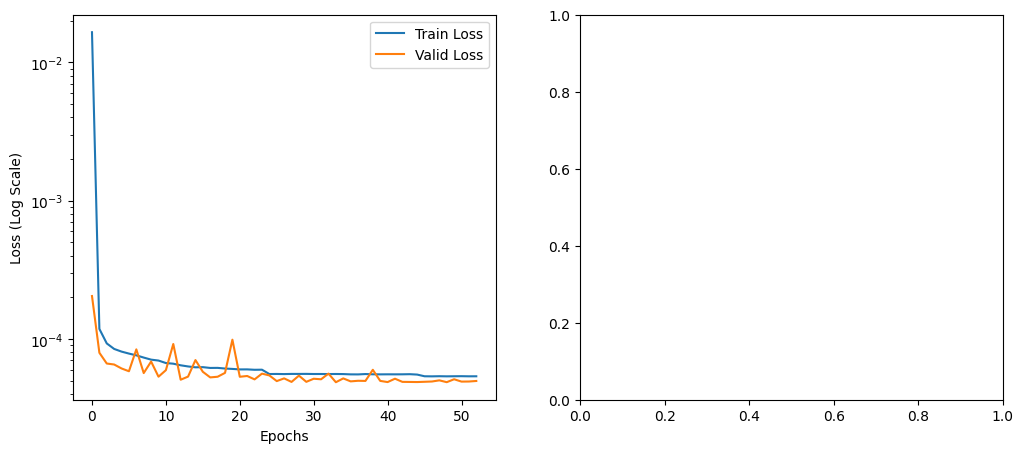

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(valid_losses, label='Valid Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.set_yscale('log')
ax1.legend()

# with torch.no_grad():
#     a = torch.linspace(-10, 10, 1000)

#     r = 2000
#     r_normalized = (torch.ones_like(a) * torch.tensor(r) - 1.7e3) / 2.5e3

#     b = model(torch.stack([a, r_normalized], dim=1))
#     a = a.detach().numpy().reshape(-1, 1)
#     b = b.detach().numpy()
#     v = (a + b) / 2
#     i = (a - b) / (2*r)

# ax2.plot(v, i*1e3)
# ax2.set_xlabel('Voltage [V]')
# ax2.set_ylabel('Current [mA]')
# ax2.set_xlim(-1, 1)
# # ax2.set_ylim(-1e-2, 1e-2)
# ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

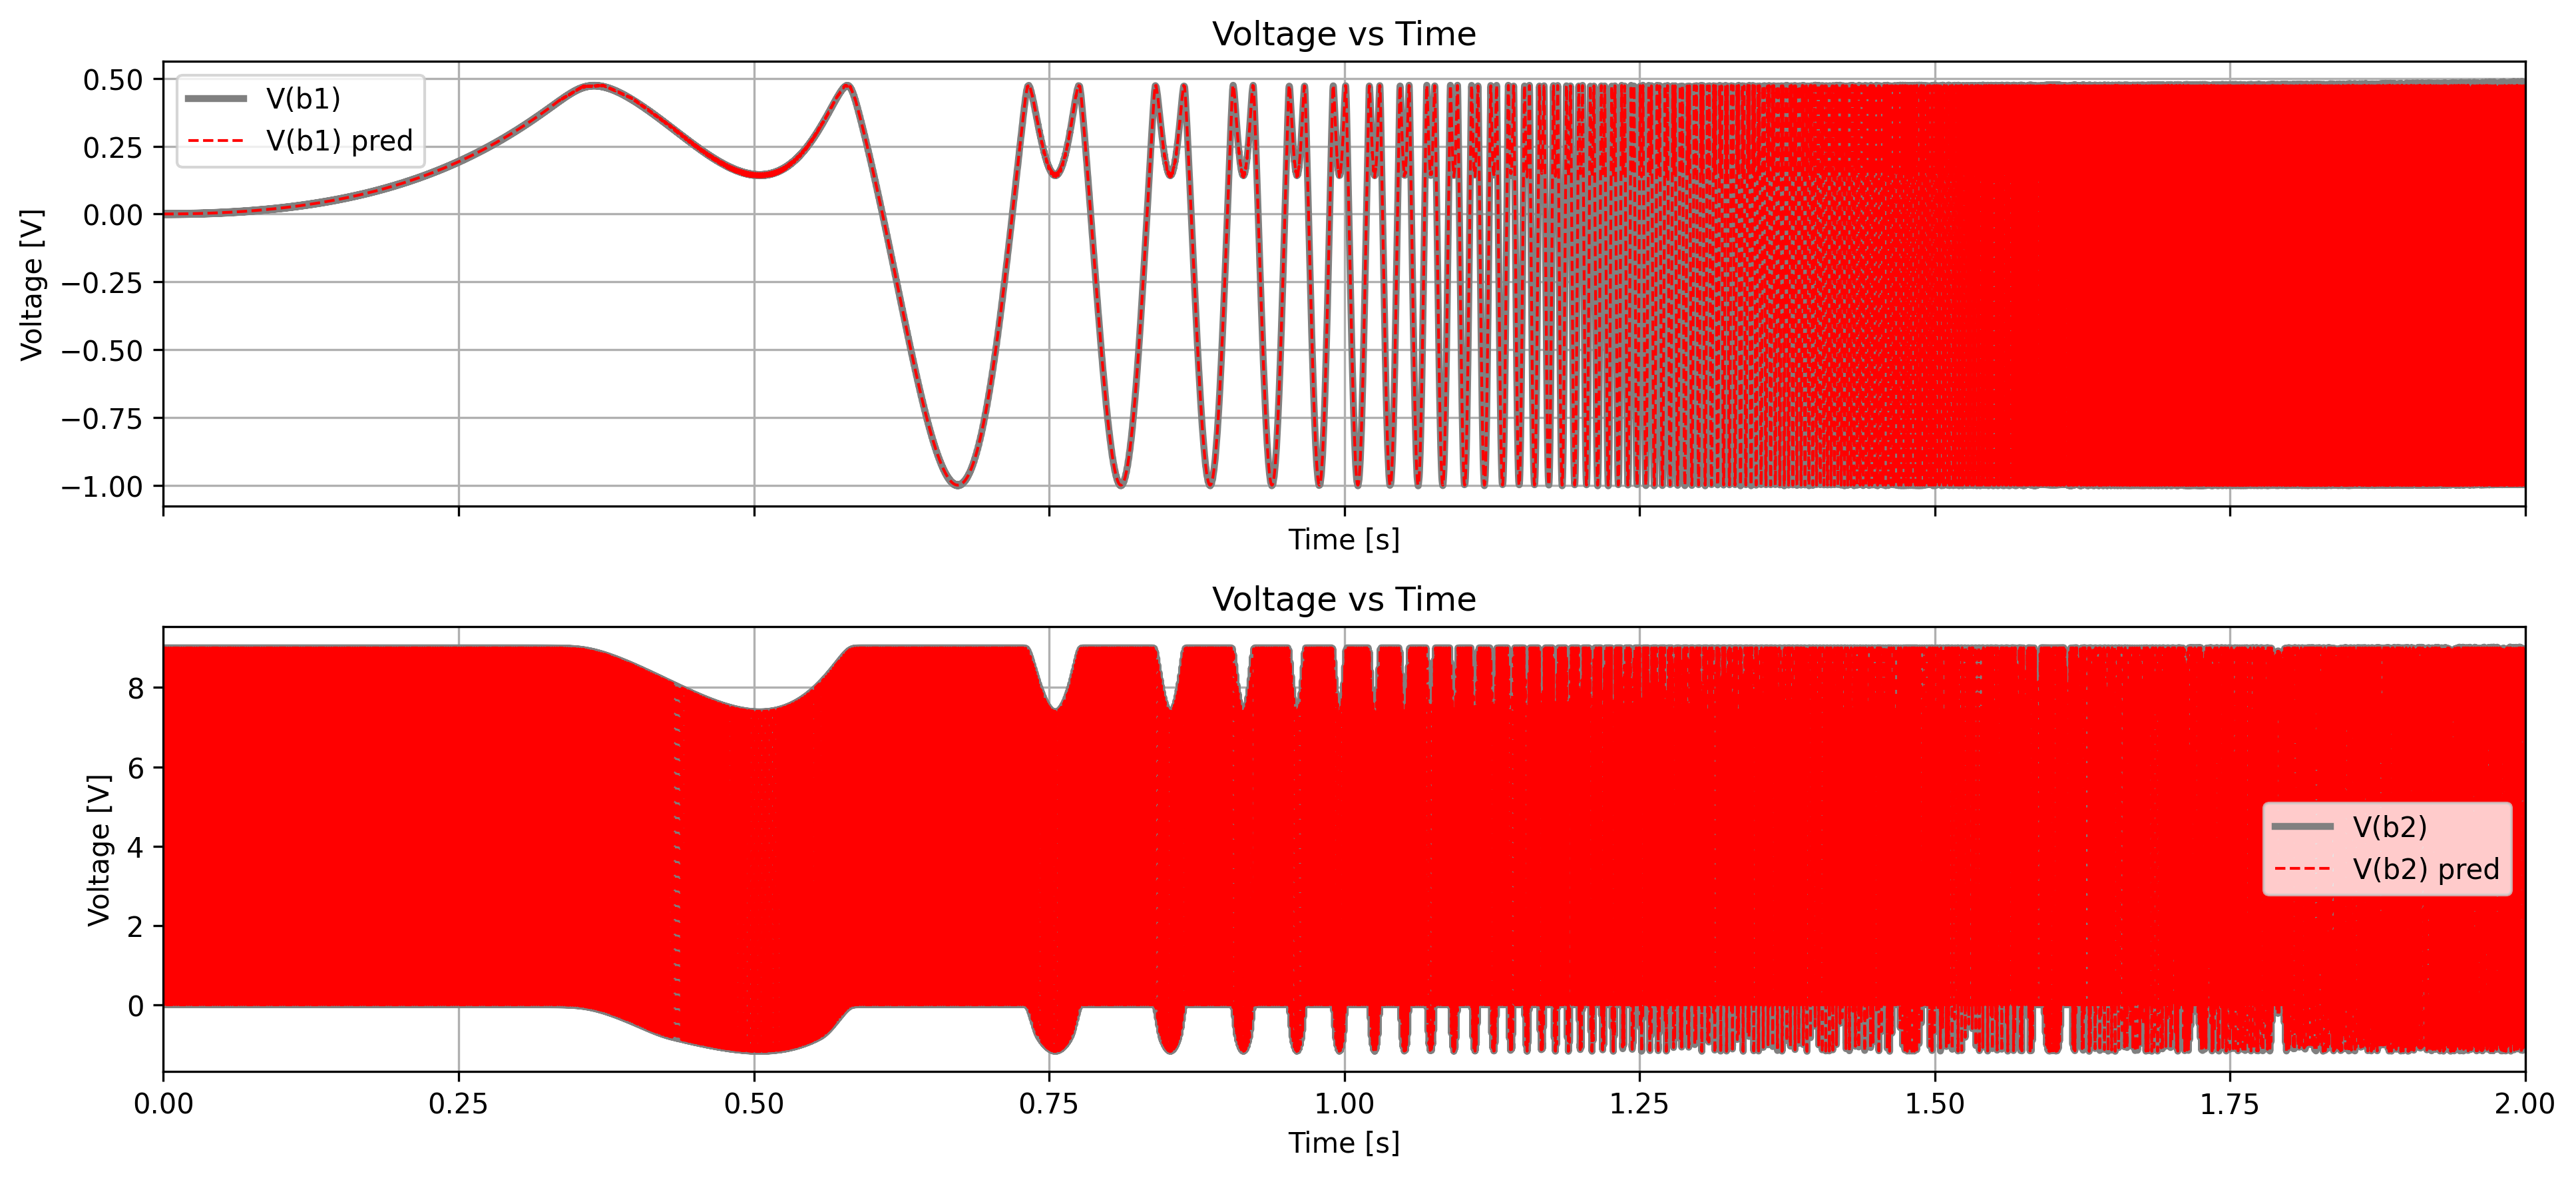

In [279]:
with torch.no_grad():
    b_pred = model(torch.tensor(a, dtype=torch.float32))
    b_pred = b_pred.detach().numpy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 6), sharex=True, dpi=300)
xlim = (0, time_raw[-1])
# xlim = (0.2, 0.21)      # Low Frequency
# xlim = (1.02, 1.04)      # Low Frequency
# xlim = (1.5, 1.51)   # Mid Frequency
# xlim = (1.999, 2)   # High Frequency

ax1.plot(time_resample, b1, color="grey", linewidth=2.5, label='V(b1)')
ax1.plot(time_resample, b_pred[:, 0], color="red", linestyle='--', linewidth=1, label='V(b1) pred')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]')
ax1.set_title('Voltage vs Time')
ax1.legend()
ax1.grid()
ax1.set_xlim(xlim)

ax2.plot(time_resample, b2, color="grey", linewidth=2.5, label='V(b2)')
ax2.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=1, label='V(b2) pred')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')
ax2.set_title('Voltage vs Time')
ax2.legend()
ax2.grid()
ax2.set_xlim(xlim)

fig.tight_layout()
plt.show()
